In [18]:
import os
import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, TensorDataset, ConcatDataset, Dataset
from torch.backends import cudnn

import torchvision
from torchvision import datasets, transforms

from tqdm import tqdm
from collections import Counter
import random
from PIL import Image


In [2]:
device = 'cuda' 
num_class = 101 
batch_size = 256    
num_epochs = 20     
step_size =  6     

In [3]:
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    return

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionando as imagens para 224x224
    transforms.ToTensor(),
])

# Carregar o dataset Caltech101
caltech101_dataset = datasets.Caltech101(
    root='C:/Users/Usuário/Desktop/machine/Trabalho_3',
    download=True,
    transform=transform
)

# Obter rótulos do dataset
labels = [target for _, target in caltech101_dataset]

class_counts = Counter(labels)
print("Contagem de amostras por classe:", class_counts)

threshold = 50 
minority_classes = [cls for cls, count in class_counts.items() if count < threshold]

# Criar um novo dataset com aumento de dados para as classes minoritárias
class AugmentedCaltech101(Dataset):
    def __init__(self, dataset, minority_classes):
        self.dataset = dataset
        self.minority_classes = minority_classes
        self.augmented_samples = []
        self.augmented_labels = []
        self.augment_data()

    def __len__(self):
        return len(self.dataset) + len(self.augmented_samples)

    def __getitem__(self, idx):
        if idx < len(self.dataset):
            return self.dataset[idx]  # Retorna amostra original
        
        return self.augmented_samples[idx - len(self.dataset)], self.augmented_labels[idx - len(self.dataset)]

    def augment_data(self):
        for idx, (image, label) in enumerate(self.dataset):
            if label in self.minority_classes:
                for _ in range(5):  # Criar 5 amostras aumentadas
                    augmented_image = image.clone() 
                    augmented_image += torch.randn_like(image) * 0.1  # Adicionando ruído
                    augmented_image = torch.clamp(augmented_image, 0, 1) 
                    self.augmented_samples.append(augmented_image)
                    self.augmented_labels.append(label)

        print(f"Foram geradas {len(self.augmented_samples)} novas amostras aumentadas.")

# Criar o dataset aumentado
augmented_dataset = AugmentedCaltech101(caltech101_dataset, minority_classes)

Files already downloaded and verified
Contagem de amostras por classe: Counter({5: 800, 3: 798, 0: 435, 1: 435, 94: 239, 2: 200, 12: 128, 19: 123, 55: 114, 23: 107, 47: 100, 46: 99, 13: 98, 16: 91, 50: 88, 63: 87, 54: 86, 86: 86, 92: 86, 15: 85, 39: 85, 90: 85, 81: 84, 75: 82, 57: 81, 51: 80, 58: 78, 65: 76, 35: 75, 93: 75, 26: 73, 27: 70, 25: 69, 34: 68, 31: 67, 40: 67, 41: 67, 60: 66, 33: 65, 36: 64, 38: 64, 53: 64, 84: 64, 88: 64, 79: 63, 22: 62, 56: 61, 100: 60, 21: 59, 76: 59, 87: 59, 96: 59, 30: 57, 74: 57, 82: 57, 98: 56, 4: 55, 66: 55, 9: 54, 49: 54, 37: 53, 72: 53, 32: 52, 29: 51, 45: 51, 17: 50, 28: 50, 77: 49, 91: 49, 8: 47, 20: 47, 24: 47, 69: 47, 10: 46, 42: 45, 71: 45, 85: 45, 14: 43, 18: 43, 61: 43, 6: 42, 7: 42, 48: 42, 59: 41, 62: 40, 78: 40, 68: 39, 80: 39, 99: 39, 70: 38, 95: 37, 67: 35, 83: 35, 89: 35, 43: 34, 44: 34, 73: 34, 97: 34, 11: 33, 64: 32, 52: 31})
Foram geradas 6860 novas amostras aumentadas.


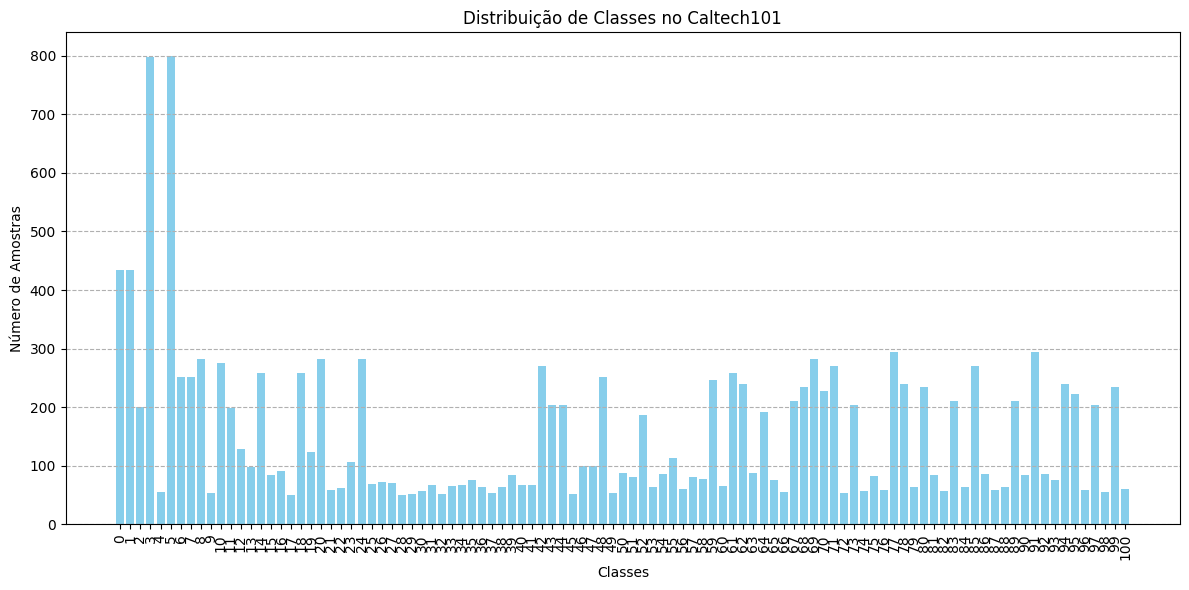

In [43]:
# Acessar os rótulos das classes
class_labels = [label for _, label in augmented_dataset]

# Contar amostras por classe
class_counts = Counter(class_labels)

# Preparar os dados para o gráfico
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.title('Distribuição de Classes no Caltech101')
plt.xticks(classes)  # Adiciona os rótulos das classes
plt.xticks(rotation=90)  # Rotaciona os rótulos para melhor visualização
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Ajusta o layout
plt.show()

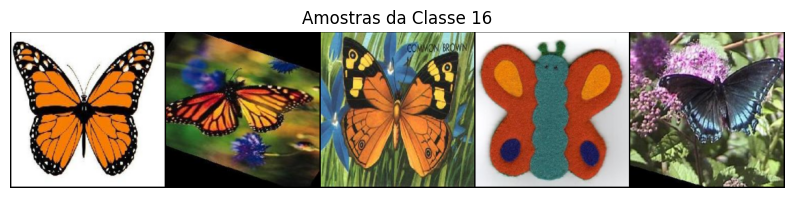

In [55]:
import torchvision.utils as vutils

def plot_images_by_class(dataset, class_idx, num_images=5):
    # Filtrar as imagens da classe selecionada
    images = [img for img, label in dataset if label == class_idx][:num_images]

    # Plotar as imagens
    plt.figure(figsize=(10, 10))
    grid_img = vutils.make_grid(images, nrow=num_images)  # As imagens já são tensores
    plt.imshow(grid_img.permute(1, 2, 0))  # Converte para formato adequado para plt.imshow
    plt.title(f'Amostras da Classe {class_idx}')
    plt.axis('off')
    plt.show()

plot_images_by_class(caltech101_dataset, class_idx=16)


In [5]:
data_dir = 'C:/Users/Usuário/Desktop/machine/Trabalho_3/caltech101/101_ObjectCategories'

from torch.utils.data import random_split

dataset_size = len(augmented_dataset)  # Tamanho total do dataset

train_size = int(0.8 * dataset_size)  # 80% para treino
val_size = int(0.1 * dataset_size)    # 10% para validação
test_size = dataset_size - train_size - val_size  # O restante para teste (10%)

# Dividindo o dataset completo em treino, validação e teste
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size])

print(f'Tamanho do treino: {len(train_dataset)}')
print(f'Tamanho da validação: {len(val_dataset)}')
print(f'Tamanho do teste: {len(test_dataset)}')

Tamanho do treino: 12429
Tamanho da validação: 1553
Tamanho do teste: 1555


In [6]:
def custom_collate_fn(batch):
    for i in range(len(batch)):
        if batch[i][0].size(0) == 1:  # Verifica se a imagem tem 1 canal (grayscale)
            batch[i] = (batch[i][0].repeat(3, 1, 1), batch[i][1])
    return torch.utils.data.dataloader.default_collate(batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=custom_collate_fn, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)

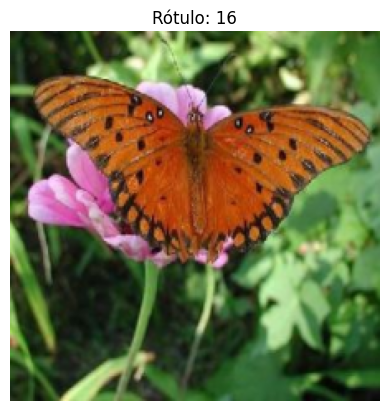

In [19]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Mostrar a primeira imagem do batch
image = images[0]  
label = labels[0].item()  

image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'Rótulo: {label}')
plt.axis('off')  
plt.show()

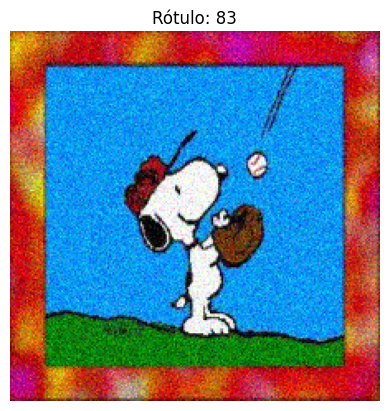

In [41]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Mostrar a primeira imagem do batch
image = images[0]  
label = labels[0].item() 

image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'Rótulo: {label}')
plt.axis('off')  
plt.show()

In [7]:
class Caltech101(nn.Module):
    def __init__(self, num_classes=101):  # 101 classes para o Caltech101
        super(Caltech101, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Saída ajustada para 101 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
from sklearn.metrics import classification_report

# Função para calcular e imprimir o classification report
def classification_report_per_class(outputs, labels):
    return classification_report(labels.cpu(), outputs.cpu(), zero_division=0)

In [9]:
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())

# Obter o número total de classes
num_classes = len(set(all_labels))
print(num_class)

101


In [10]:
# Definindo a seed
seed = 42
random.seed(seed)

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # Para garantir que os resultados sejam determinísticos
torch.backends.cudnn.benchmark = False  

epoch_loss_train = []
epoch_loss_val = []
epoch_acc_val = []
epoch_acc_train = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciar o modelo
model = Caltech101().to(device)

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

for epoch in range(20):  # 20 épocas
    model.train()
    running_loss_train = 0.0
    running_corrects_train = 0

    for inputs, labels in train_dataloader:  
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()  # Zerar gradientes

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss_train += loss.item() * inputs.size(0) 
        running_corrects_train += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_train.append(running_loss_train / len(train_dataloader.dataset))
    epoch_acc_train.append(running_corrects_train / len(train_dataloader.dataset))

    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:  
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 
            loss = criterion(outputs, labels)
            all_preds.append(preds)
            all_labels.append(labels)

            # Estatísticas
            running_loss_val += loss.item() * inputs.size(0) 
            running_corrects_val += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_val.append(running_loss_val / len(val_dataloader.dataset))
    epoch_acc_val.append(running_corrects_val / len(val_dataloader.dataset))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Imprimir as estatísticas de cada época
    print(f"Época {epoch+1}/20")
    print(f"  Treino - Loss: {epoch_loss_train[-1]:.4f}, Acurácia: {epoch_acc_train[-1]:.4f}")
    print(f"  Validação - Loss: {epoch_loss_val[-1]:.4f}, Acurácia: {epoch_acc_val[-1]:.4f}")

Época 1/20
  Treino - Loss: 4.3606, Acurácia: 0.0414
  Validação - Loss: 4.2727, Acurácia: 0.0496
Época 2/20
  Treino - Loss: 4.2253, Acurácia: 0.0554
  Validação - Loss: 4.1660, Acurácia: 0.0734
Época 3/20
  Treino - Loss: 4.0267, Acurácia: 0.0885
  Validação - Loss: 3.7907, Acurácia: 0.1359
Época 4/20
  Treino - Loss: 3.5489, Acurácia: 0.1785
  Validação - Loss: 3.2230, Acurácia: 0.2601
Época 5/20
  Treino - Loss: 2.9296, Acurácia: 0.3116
  Validação - Loss: 2.5713, Acurácia: 0.3934
Época 6/20
  Treino - Loss: 2.3432, Acurácia: 0.4296
  Validação - Loss: 2.0557, Acurácia: 0.5126
Época 7/20
  Treino - Loss: 1.8257, Acurácia: 0.5431
  Validação - Loss: 1.5867, Acurácia: 0.6394
Época 8/20
  Treino - Loss: 1.3782, Acurácia: 0.6462
  Validação - Loss: 1.2734, Acurácia: 0.7044
Época 9/20
  Treino - Loss: 1.0882, Acurácia: 0.7125
  Validação - Loss: 1.0508, Acurácia: 0.7572
Época 10/20
  Treino - Loss: 0.8468, Acurácia: 0.7661
  Validação - Loss: 0.9464, Acurácia: 0.7817
Época 11/20
  Trein

In [11]:
print(classification_report_per_class(all_preds, all_labels))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.97      1.00      0.99        39
           2       0.87      0.95      0.91        21
           3       0.96      0.97      0.96        88
           4       0.67      0.29      0.40         7
           5       0.90      0.95      0.92        76
           6       0.97      1.00      0.99        34
           7       0.97      0.97      0.97        30
           8       0.97      0.94      0.95        31
           9       0.50      0.33      0.40         9
          10       0.94      1.00      0.97        29
          11       0.89      1.00      0.94        25
          12       0.62      0.53      0.57        15
          13       1.00      0.33      0.50         9
          14       0.91      1.00      0.95        29
          15       0.38      0.33      0.35         9
          16       0.27      0.36      0.31        11
          17       0.50    

In [62]:
torch.save(model, 'ModeloNNCompleto.pth')

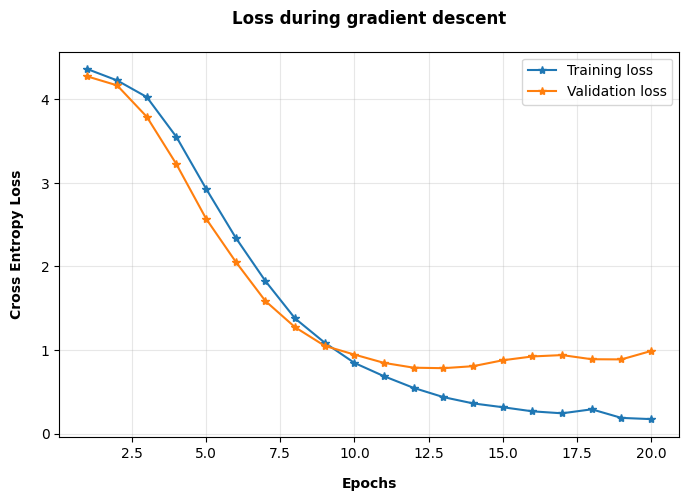

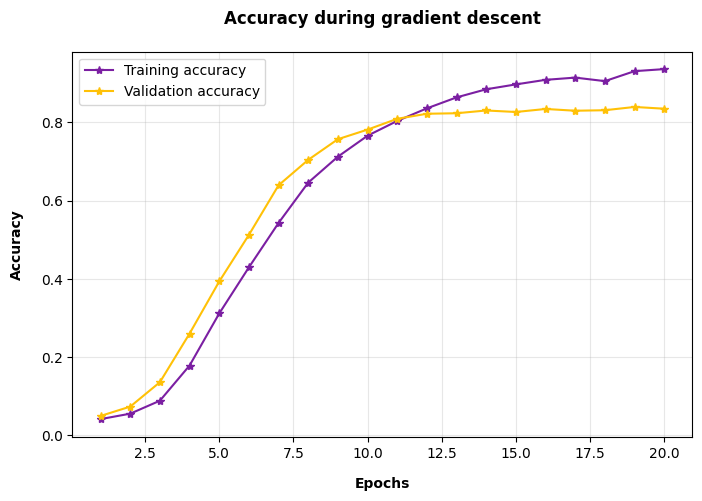

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_loss_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, epoch_loss_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_acc_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, epoch_acc_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def precision(outputs, labels):
    return precision_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def recall(outputs, labels):
    return recall_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def f1(outputs, labels):
    return f1_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

In [14]:
def evaluate_on_test(model, test_dataloader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    test_running_loss = 0.0
    test_running_corrects = 0
    all_preds = []
    all_labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Predições
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)
            
            test_running_loss += loss.item() * inputs.size(0)
            test_running_corrects += (preds == labels).sum().item()

    # Calcular loss e acurácia médios
    test_loss = test_running_loss / len(test_dataloader.dataset)
    test_acc = test_running_corrects / len(test_dataloader.dataset)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    test_precision = precision(all_preds, all_labels)
    test_recall = recall(all_preds, all_labels)
    test_f1 = f1(all_preds, all_labels)

    print(f"Teste - Loss: {test_loss:.4f}, Acurácia: {test_acc:.4f}")
    print(f"Precisão: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

    return test_loss, test_acc, test_precision, test_recall, test_f1

In [15]:
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_on_test(model, test_dataloader, device)

Teste - Loss: 1.2429, Acurácia: 0.7852
Precisão: 0.7738, Recall: 0.7852, F1-Score: 0.7630


In [16]:
def count_zero_precision_recall(y_true, y_pred, num_classes=101):
    precision = []
    recall = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for class_label in range(num_classes):
        precision_value = precision_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        recall_value = recall_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        precision.append(precision_value)
        recall.append(recall_value)

    precision = np.array(precision)
    recall = np.array(recall)

    zero_precision_classes = [i for i in range(num_classes) if precision[i] == 0]
    zero_recall_classes = [i for i in range(num_classes) if recall[i] == 0]
    
    print(f"Número de classes com Precision = 0: {len(zero_precision_classes)}")
    print(f"Classes com Precision = 0: {zero_precision_classes}")

    print(f"Número de classes com Recall = 0: {len(zero_recall_classes)}")
    print(f"Classes com Recall = 0: {zero_recall_classes}")

    zero_classes = set(zero_precision_classes) & set(zero_recall_classes)
    print(f"Número de classes com Precision e Recall = 0: {len(zero_classes)}")
    print(f"Classes com Precision e Recall = 0: {zero_classes}")
    
count_zero_precision_recall(all_labels.cpu(),all_preds.cpu(), num_classes=101)

Número de classes com Precision = 0: 9
Classes com Precision = 0: [27, 28, 29, 37, 45, 54, 57, 82, 93]
Número de classes com Recall = 0: 9
Classes com Recall = 0: [27, 28, 29, 37, 45, 54, 57, 82, 93]
Número de classes com Precision e Recall = 0: 9
Classes com Precision e Recall = 0: {37, 45, 82, 29, 54, 57, 27, 28, 93}


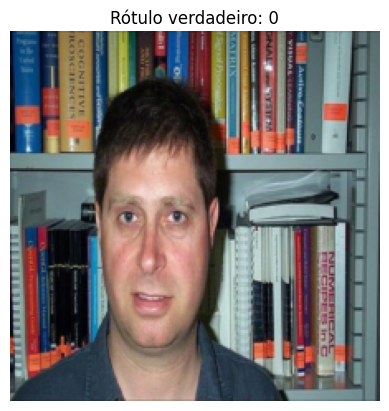

Classe prevista: 0


In [109]:
modelX = Caltech101().to(device)
modelX.load_state_dict(torch.load('ModeloNNCompleto.pth', weights_only=False))
modelX.eval()  # Coloca o modelo em modo de avaliação

def predict_image(model, dataset, index):
    modelX.eval()
    img, label = dataset[index]
    
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'Rótulo verdadeiro: {label}')
    plt.axis('off')
    plt.show()

    img = img.unsqueeze(0).to(device)  # Adicionar uma dimensão para batch

    with torch.no_grad():
        output = modelX(img)
        _, predicted = torch.max(output, 1)

    print(f"Classe prevista: {predicted.item()}")

# Exemplo de previsão
predict_image(modelX, augmented_dataset, index=1)